# Introduction
In this tutorial, we will explore *prospective learning* in a task switch scenario. 

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import seaborn as sns

font = {'size':24}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
colors = {'OGD': '#4daf4a', 'FTL': '#377eb8', 'Prospective MLP': '#e41a1c','BGD':'#984ea3'}
plt.style.use("seaborn-v0_8-whitegrid")

sns.set(context='poster',
        style='ticks',
        font_scale=.75,
        rc={'axes.grid': True,
            'grid.color': '.9',
            'grid.linewidth': 0.75})

In [2]:
def online_sample_from_task_sequence(t, N=20):
    # Determine which task we are in at time t
    task = (t // N) % 2 + 1

    # Sample X from the uniform distribution on the set [-2, -1] U [1, 2]
    X = np.random.choice([-1, 1]) * (1 + np.random.rand())

    # Determine label Y based on the current task
    if task == 1:
        Y = np.sign(X)
    else:
        Y = -np.sign(X)

    return X, Y

def batch_sample_for_future_points(n, t, T, N=20, seed=1996):
    np.random.seed(seed)
    X = []
    Y = []

    for future_t in range(t, T):
        task = (future_t // N) % 2 + 1
        x_batch = np.random.choice([-1, 1], size=n) * (1 + np.random.rand(n))

        if task == 1:
            y_batch = np.sign(x_batch)
        else:
            y_batch = -np.sign(x_batch)

        X.append(x_batch)
        Y.append(y_batch)

    return np.array(X), np.array(Y)

def batch_sample_from_past_points(n, t, N=20, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = []
    Y = []
    t_list = []

    for _ in range(n):
        past_t = np.random.randint(1, t + 1)  # Sample a past time step
        task = (past_t // N) % 2 + 1
        x_sample = np.random.choice([-1, 1]) * (1 + np.random.rand())

        if task == 1:
            y_sample = np.sign(x_sample)
        else:
            y_sample = -np.sign(x_sample)

        X.append(x_sample)
        Y.append(y_sample)
        t_list.append(past_t)

    return np.array(X), np.array(Y), np.array(t_list)

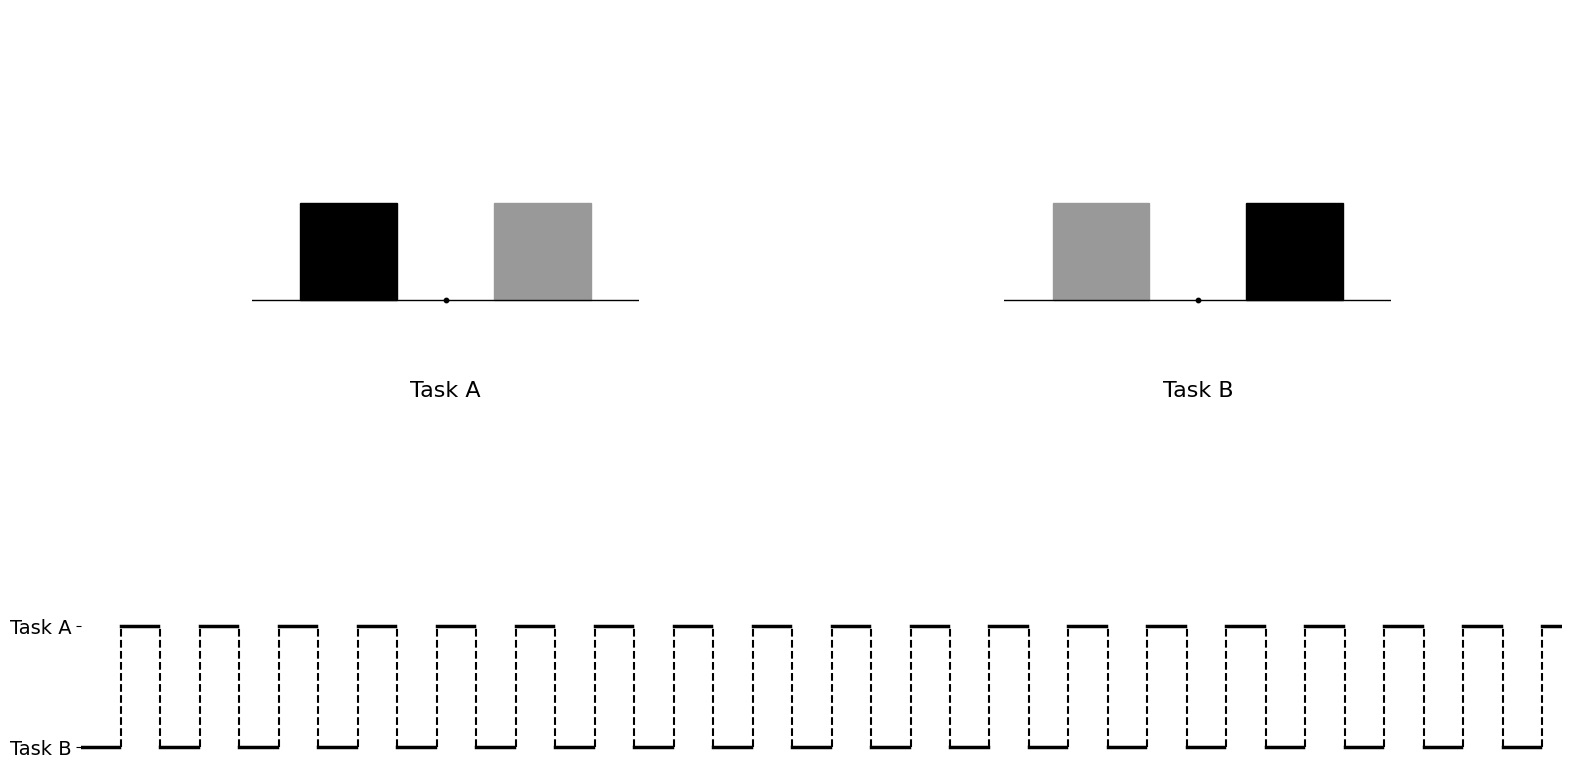

In [3]:
# Function to plot individual tasks (Task A and Task B)
def plot_task(ax, task_name, y_offset, colors, fontsize):
    # Draw rectangles and a central scatter point
    ax.add_patch(Rectangle((-1.5, y_offset), 1, 1, color=colors[0], alpha=1))  # Left rectangle
    ax.add_patch(Rectangle((0.5, y_offset), 1, 1, color=colors[1], alpha=1))   # Right rectangle
    ax.scatter(0, y_offset, color='black', s=10)  # Center point

    # Customize plot limits and appearance
    ax.set_xlim([-2, 2])  
    ax.set_ylim([-3, 3])  

    # Remove ticks and spines for clean appearance
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ['left', 'bottom', 'right', 'top']:
        ax.spines[spine].set_color('none')
    
    # Horizontal line and text annotation
    ax.axhline(y=y_offset, color='black', linewidth=1)
    ax.set_aspect('equal')
    ax.text(0, y_offset - 1, task_name, fontsize=fontsize, ha='center')

# Function to plot task execution in the merged cell
def plot_task_executing(start_time, end_time, N, fontsize, ax):
    times = np.arange(start_time, end_time, 1)
    task1_y = np.zeros_like(times)
    task2_y = np.ones_like(times)

    # Draw task execution lines and task switches
    for i in range(start_time, end_time, 2 * N):
        ax.plot(times[i:i + N], task1_y[i:i + N], color='black', lw=2.5)
        ax.plot(times[i + N:i + 2 * N], task2_y[i + N:i + 2 * N], color='black', lw=2.5)

    # Add dashed lines to indicate task switching
    for i in range(start_time + N, end_time, N):
        ax.plot([times[i], times[i]], [0, 1], color='black', linestyle='dashed', lw=1.5)

    # Customize plot appearance
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Task B', 'Task A'], fontsize=fontsize)
    ax.set_xticks([])
    ax.set_xlim([start_time, end_time])
    ax.set_ylim([-0.1, 1.1])
    ax.set_frame_on(False)
    ax.grid(False)

# Set up a 2x2 grid and merge the second row into a single plot for task execution
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, .25])

# Plot Task A in [0, 0]
ax1 = fig.add_subplot(gs[0, 0])
colors_task_A = ['#000000', '#999999']  # Black and gray
plot_task(ax1, 'Task A', 0, colors_task_A, 16)

# Plot Task B in [0, 1]
ax2 = fig.add_subplot(gs[0, 1])
colors_task_B = ['#999999', '#000000']  # Gray and black
plot_task(ax2, 'Task B', 0, colors_task_B, 16)

# Plot task executing across the entire second row ([1, :])
ax3 = fig.add_subplot(gs[1, :])
plot_task_executing(0, 750, 20, 14, ax3)

# Adjust layout to prevent overlap and make the display clean
plt.tight_layout()


# Online- and Continual-learning algorithms are falling short

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class MLP_3L(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(MLP_3L, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def qplot_errors(inst_errors, pros_errors, c_inst, c_pro, label_name=None, tstart=0, tend=200, k=100, col='b'):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Horizontal layout with two plots

    # Define alternating background colors for task switching visualization
    task_colors = ['#D4BEE4', '#BFECFF']
    fontsize = 24  

    # Plot Instantaneous Error with shaded confidence interval
    time_points_inst = np.arange(tstart, tend)
    inst_errors_section = inst_errors[tstart:tend]
    c_ogd_section = c_inst[tstart:tend]
    
    axes[0].plot(time_points_inst, inst_errors_section, label=f'{label_name} - Instantaneous', color=col)
    axes[0].fill_between(time_points_inst, inst_errors_section - c_ogd_section, inst_errors_section + c_ogd_section, color=col, alpha=0.2)
    
    current_color_index = 0
    for start in range(tstart, tend, 20):
        end = min(start + 20, tend)
        axes[0].axvspan(start, end, facecolor=task_colors[current_color_index % 2], alpha=1)
        current_color_index += 1
    
    axes[0].set_xticks(np.arange(tstart, tend, 20))
    axes[0].set_xlim([tstart, tend])
    axes[0].set_xlabel("Time", fontsize=fontsize)
    axes[0].set_ylabel("Instantaneous Error", fontsize=fontsize)
    if label_name:
        axes[0].legend(loc="upper right")

    # Plot Prospective Error with shaded confidence interval
    time_points_pros = np.arange(tstart, tend, k)
    pros_errors_section = pros_errors[:len(time_points_pros)]
    c_ogd_prospective_section = c_pro[:len(time_points_pros)]
    
    axes[1].plot(time_points_pros, pros_errors_section, label=f'{label_name} - Prospective', color=col)
    axes[1].fill_between(time_points_pros, pros_errors_section - c_ogd_prospective_section, pros_errors_section + c_ogd_prospective_section, color=col, alpha=0.2)

    current_color_index = 0
    for start in range(tstart, tend, 20):
        end = min(start + 20, tend)
        axes[1].axvspan(start, end, facecolor=task_colors[current_color_index % 2], alpha=1)
        current_color_index += 1
    
    axes[1].set_xticks(np.arange(tstart, tend, 20))
    axes[1].set_xlim([tstart, tend])
    axes[1].set_xlabel("Time", fontsize=fontsize)
    axes[1].set_ylabel("Prospective Error", fontsize=fontsize)
    if label_name:
        axes[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()


## Online Gradient Descent (OGD)
Online Gradient Descent (OGD) is an incremental learning approach that updates model weights continuously as new data arrives. It’s efficient for scenarios with gradual changes in data distribution since it only requires the current data point to make updates. In each step, OGD adjusts the weights by taking a small gradient descent step, helping it stay relevant without requiring full retraining.

In [48]:
# Parameters
N = 20
T = 300
n_test = 10
n_reps = 5
k = 5  # parameter for prospective error interval

# Ensure device is set to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define OGD loop function using PyTorch and the new MLP model
def ogd_loop_torch():
    # Initialize the MLP model and optimizer
    model = MLP_3L(1,1,32).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    ogd_error = []
    prospective_errors = []

    for t in range(1, T + 1):
        # Obtain new sample from the online sampling function
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([[x]], device=device, dtype=torch.float32)  # Adjusted shape for MLP
        y = torch.tensor([[y]], device=device, dtype=torch.float32)

        # Obtain test samples for evaluation at time t
        X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
        X_test = torch.tensor(X_test[0], device=device, dtype=torch.float32).view(-1, 1)
        Y_test = torch.tensor(Y_test[0], device=device, dtype=torch.float32).view(-1, 1)

        # Make predictions and calculate current error
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            Y_hat = torch.sign(model(X_test))
        ogd_error.append((Y_test != Y_hat).float().mean().item())

        # Calculate prospective errors every k steps
        if t % k == 0:
            # Obtain test samples for future evaluation from t to T
            X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
            future_errors = []

            for future_idx in range(len(X_future)):
                X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)

                # Make predictions for future points and calculate error
                with torch.no_grad():
                    Y_hat_future = torch.sign(model(X_future_test))
                future_errors.append((Y_future_test != Y_hat_future).float().mean().item())

            # Calculate the mean prospective error for the current time step
            prospective_errors.append(np.mean(future_errors))

        # Online gradient descent update
        model.train()  # Set model to training mode
        optimizer.zero_grad()
        loss = torch.nn.BCEWithLogitsLoss()(model(x), (y + 1) / 2)  # Use BCE with target in range [0,1]
        loss.backward()
        optimizer.step()

    return ogd_error, prospective_errors

ogd_error_reps = []
prospective_error_reps = []

for _ in range(n_reps):
    ogd_error, prospective_errors = ogd_loop_torch()

    # Move results to CPU to free GPU memory
    ogd_error_reps.append(torch.tensor(ogd_error).cpu())
    prospective_error_reps.append(torch.tensor(prospective_errors).cpu())

    # Clear GPU memory after each repetition
    torch.cuda.empty_cache()

ogd_error_reps = torch.stack(ogd_error_reps)
prospective_error_reps = torch.stack(prospective_error_reps)

# Calculate Instantanous and Prospective errors over n_reps
ogd_error = ogd_error_reps.mean(dim=0).numpy()
ogd_prospective_error = prospective_error_reps.mean(dim=0).numpy()
c_ogd = ogd_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
c_ogd_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5)

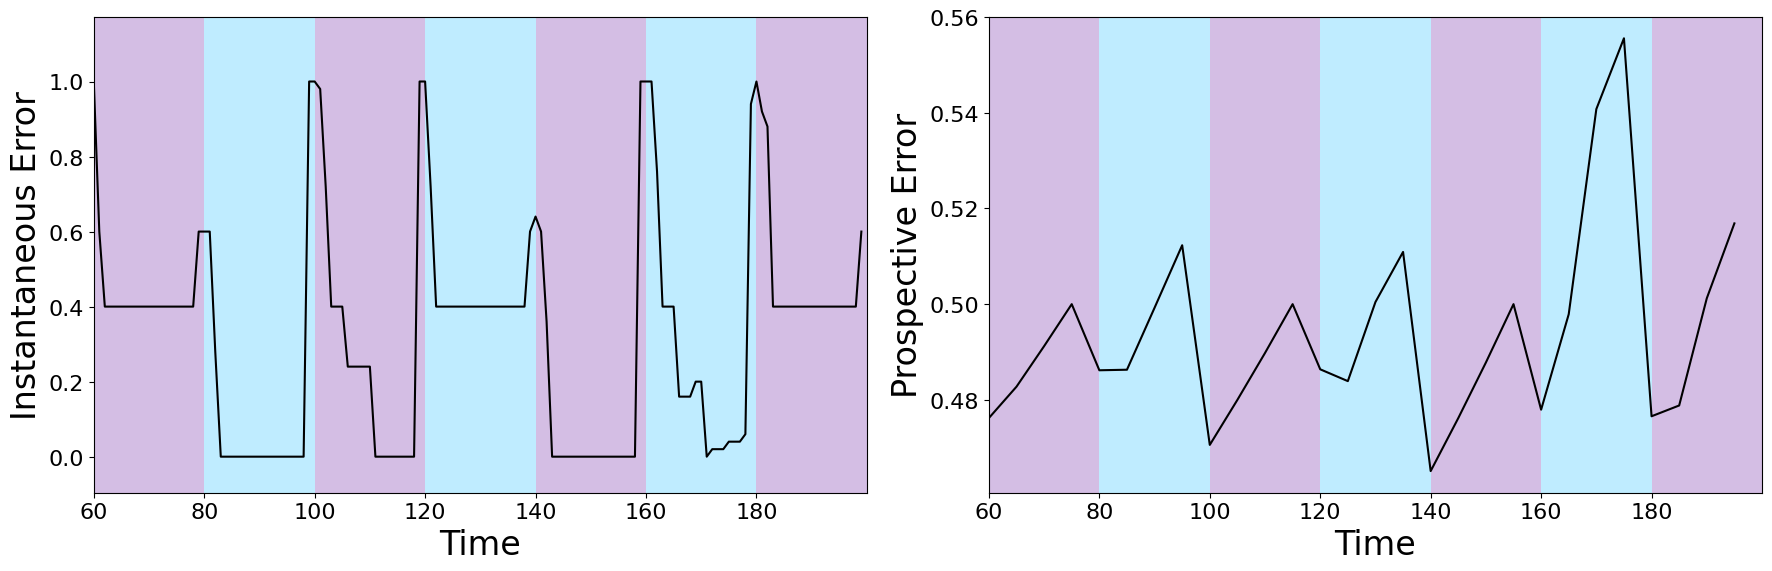

In [56]:
qplot_errors(ogd_error, ogd_prospective_error,c_ogd,c_ogd_prospective, tstart=60,tend=200, col='k',k=5)

## Follow-the-Leader (FTL)
Follow-the-Leader (FTL) is a strategy that uses historical data to guide future predictions. Unlike OGD, which uses only the most recent data, FTL aggregates past information to minimize cumulative loss over time. This approach is beneficial in settings where patterns in the data remain consistent, although it may face challenges if the data distribution is highly volatile.


In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define FTL loop function using 3-layer MLP in PyTorch
def ftl_loop_torch(k):
    # Initialize MLP model and optimizer
    model = MLP_3L(1, 1, 32).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Initialize empty training data
    X_train = torch.empty((0, 1), device=device)
    Y_train = torch.empty((0,), device=device)

    ftl_error = []
    prospective_errors = []

    for t in range(1, T):
        # Obtain new sample from the online sampling function
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([x], device=device, dtype=torch.float32).view(1, 1)
        y = torch.tensor([y], device=device, dtype=torch.float32).view(1)

        # Obtain test samples for evaluation at time t
        X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
        X_test = torch.tensor(X_test, device=device, dtype=torch.float32).view(-1, 1)
        Y_test = torch.tensor(Y_test, device=device, dtype=torch.float32).view(-1)

        # Make predictions and calculate current error
        model.eval()
        with torch.no_grad():
            Y_hat = torch.sign(model(X_test))
        Y_hat = Y_hat.view(-1)
        error = (Y_test != Y_hat).float().mean().item()
        ftl_error.append(error)

        # Only calculate prospective errors for t = k, 2k, 3k, ...
        if t % k == 0:
            X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
            future_errors = []

            for future_idx in range(len(X_future)):
                X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32).view(-1)

                with torch.no_grad():
                    Y_hat_future = torch.sign(model(X_future_test))
                Y_hat_future = Y_hat_future.view(-1)
                future_error = (Y_future_test != Y_hat_future).float().mean().item()
                future_errors.append(future_error)

            prospective_errors.append(np.mean(future_errors))

        # Update training set
        X_train = torch.cat((X_train, x.view(1, 1)), dim=0)
        Y_train = torch.cat((Y_train, y), dim=0)

        # Train the model if enough samples have been collected
        if (Y_train == -1).sum() >= 25 and (Y_train == 1).sum() >= 25:
            model.train()
            optimizer.zero_grad()
            Y_train_binary = (Y_train + 1) / 2  # Convert labels to binary [0, 1] for BCEWithLogitsLoss
            predictions = model(X_train)
            loss = criterion(predictions, Y_train_binary.unsqueeze(1))
            loss.backward()
            optimizer.step()

    return ftl_error, prospective_errors

ftl_error_reps = []
prospective_error_reps = []

for _ in range(n_reps):
    ftl_error, prospective_errors = ftl_loop_torch(k)
    
    # Move results to CPU to free GPU memory
    ftl_error_reps.append(torch.tensor(ftl_error).cpu())
    prospective_error_reps.append(torch.tensor(prospective_errors).cpu())
    
    # Clear GPU memory after each repetition
    torch.cuda.empty_cache()

# Convert lists to tensors
ftl_error_reps = torch.stack(ftl_error_reps)
prospective_error_reps = torch.stack(prospective_error_reps)

# Calculate mean and confidence intervals
ftl_error = ftl_error_reps.mean(dim=0).numpy()
ftl_prospective_error = prospective_error_reps.mean(dim=0).numpy()
c_ftl = ftl_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
c_ftl_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96


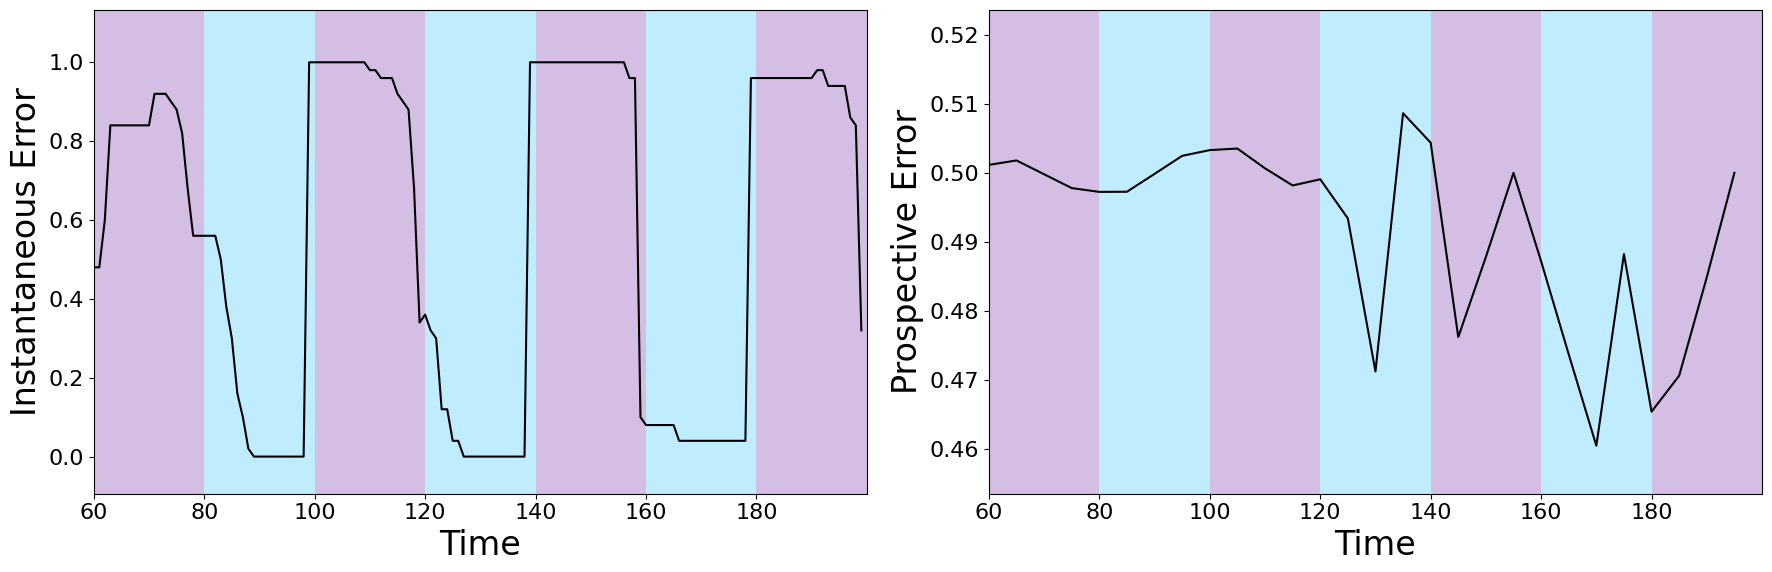

In [55]:
qplot_errors(ftl_error, ftl_prospective_error,c_ftl,c_ftl_prospective, tstart=60,tend=200, col='k',k=5)

## Bayesian Gradient Descent (BGD)
Bayesian Gradient Descent (BGD) enhances the standard gradient descent approach by introducing a Bayesian framework, which maintains a distribution over model weights. This probabilistic approach captures uncertainty in parameter estimates, making BGD adaptable in environments where data distributions are unstable. By maintaining a range of possible weights, BGD is more flexible and robust to shifts in the data distribution.

In [52]:
lr = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# BGD Loop with KL Divergence
def bgd_loop_torch():
    # Initialize MLP model
    model = MLP_3L(1, 1, 32).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    bgd_error = []
    prospective_errors = []

    # Fixed variance for simplicity
    sigma = 1.
    kl_weight = 0.01  # Weight for KL-divergence term to balance regularization

    for t in range(1, T + 1):
        # Obtain new sample
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([[x]], device=device, dtype=torch.float32)
        y = torch.tensor([[y]], device=device, dtype=torch.float32)

        # Forward pass with weight perturbation
        model.train()
        optimizer.zero_grad()

        # Apply random noise to model parameters to simulate weight sampling
        original_state = model.state_dict()
        for param in model.parameters():
            param.data += sigma * torch.randn_like(param)

        # Compute output and classification loss
        output = model(x)
        loss = torch.nn.BCEWithLogitsLoss()(output, (y + 1) / 2)

        # KL-divergence term for regularization (weights close to zero)
        kl_divergence = 0.5 * sum((param ** 2).sum() for param in model.parameters())

        # Total loss: classification loss + KL divergence
        total_loss = loss + kl_weight * kl_divergence
        total_loss.backward()

        # Restore original parameters before optimizer step
        model.load_state_dict(original_state)
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            # Test error at time t
            X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
            X_test = torch.tensor(X_test[0], device=device, dtype=torch.float32).view(-1, 1)
            Y_test = torch.tensor(Y_test[0], device=device, dtype=torch.float32).view(-1, 1)
            Y_hat = torch.sign(model(X_test))
            error = (Y_test != Y_hat).float().mean().item()
            bgd_error.append(error)

            # Prospective errors every k steps
            if t % k == 0:
                X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
                future_errors = []
                for future_idx in range(len(X_future)):
                    X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                    Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                    Y_hat_future = torch.sign(model(X_future_test))
                    future_error = (Y_future_test != Y_hat_future).float().mean().item()
                    future_errors.append(future_error)
                prospective_errors.append(np.mean(future_errors))

    return bgd_error, prospective_errors

bgd_error_reps = []
prospective_error_reps = []

for _ in range(n_reps):
    bgd_error, prospective_errors = bgd_loop_torch()

    # Move results to CPU to free GPU memory
    bgd_error_reps.append(torch.tensor(bgd_error).cpu())
    prospective_error_reps.append(torch.tensor(prospective_errors).cpu())

    # Clear GPU memory after each repetition
    torch.cuda.empty_cache()

# Convert lists to tensors
bgd_error_reps = torch.stack(bgd_error_reps)
prospective_error_reps = torch.stack(prospective_error_reps)

# Calculate mean and confidence intervals
bgd_error = bgd_error_reps.mean(dim=0).numpy()
bgd_prospective_error = prospective_error_reps.mean(dim=0).numpy()
c_bgd = bgd_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
c_bgd_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96

/home/honglab/leijiaxin/anaconda3/envs/cuda_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/honglab/leijiaxin/anaconda3/envs/cuda_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


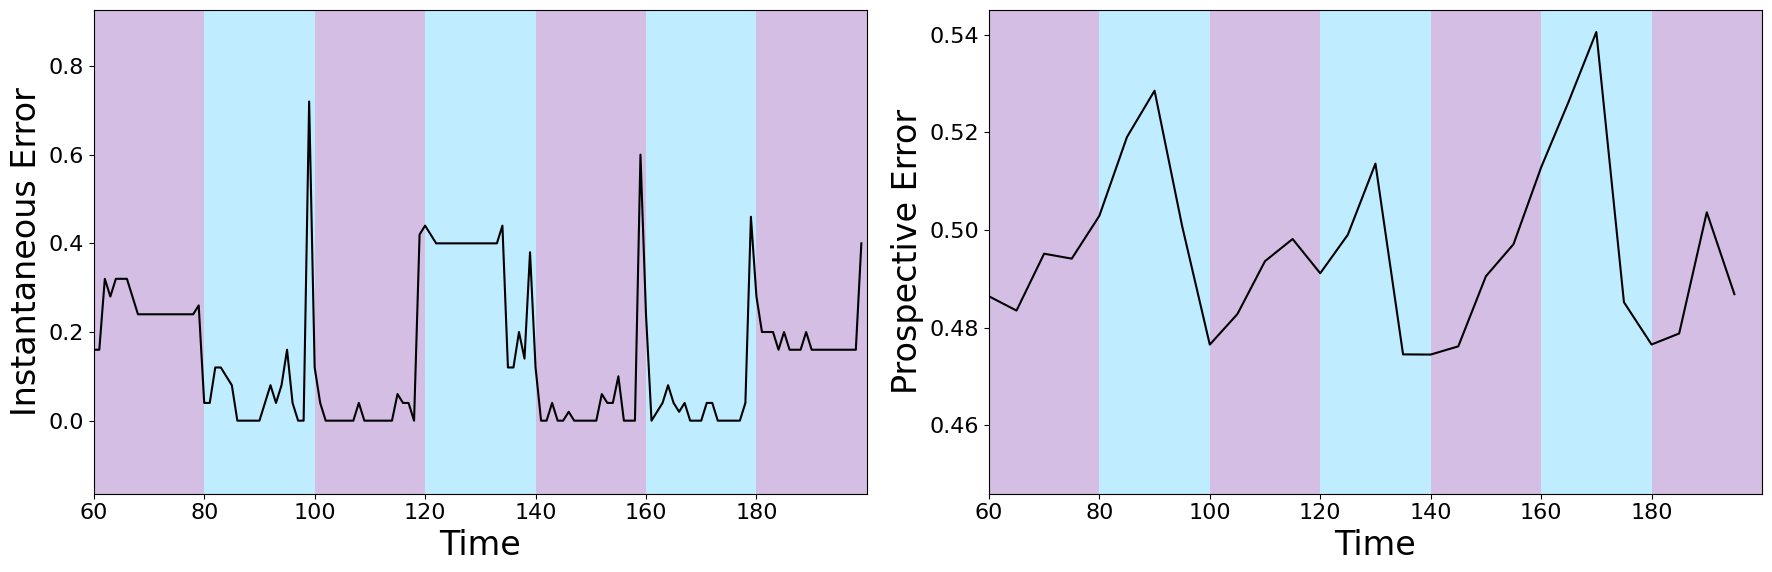

In [54]:
qplot_errors(bgd_error, bgd_prospective_error,c_bgd,c_bgd_prospective, tstart=60,tend=200, col='k',k=5)

## Prospective ERM (Empirical Risk Minimization)
Prospective ERM is specifically designed for environments where the optimal model hypothesis changes over time. Unlike traditional ERM, which operates in a static context, Prospective ERM integrates time as a critical factor, aiming to minimize the error across future predictions. By adapting the model to anticipate changes in the data distribution, Prospective ERM provides a robust framework for dynamic environments.

In [ ]:
# Synthetic data generation classes
class SyntheticScenario2:
    def __init__(self, seq_len=500, numseeds=5, period=20):
        self.seq_len = seq_len
        self.num_seeds = numseeds
        self.period = period

    def generate_data(self):
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for sd in range(self.num_seeds):
            dat = self.gen_sequence(np.random.randint(0, 10000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(np.arange(self.seq_len))

        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def gen_sequence(self, seed):
        np.random.seed(seed)

        # Generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, self.seq_len)
        x2 = np.random.uniform(1, 2, self.seq_len)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=self.seq_len)
        Xdat = x1 * mask + x2 * (1 - mask)

        # Create labels
        T = self.period
        tind = np.array((np.arange(0, self.seq_len) % T) < (T // 2))
        tind = tind.astype(int)
        ind = np.where(tind == 1)[0]

        Ydat = Xdat > 0
        Ydat[ind] = Xdat[ind] < 0
        Ydat = Ydat.astype(int)

        Xdat = Xdat.reshape(-1, 1)

        return Xdat, Ydat, tind

class SyntheticDataset(Dataset):
    def __init__(self, data, idx, run_id, test, past=None):
        self.x = data['x']
        self.y = data['y']
        self.t = data['t']

        if test:
            # Use data from time 'idx' onwards for testing
            self.x = self.x[run_id, idx:]
            self.y = self.y[run_id, idx:]
            self.t = self.t[run_id, idx:]
        else:
            if past is None:
                # Use all data up to time 'idx' for training
                self.x = self.x[run_id, :idx]
                self.y = self.y[run_id, :idx]
                self.t = self.t[run_id, :idx]
            else:
                # Use the most recent 'past' data points for training
                self.x = self.x[run_id, idx - past:idx]
                self.y = self.y[run_id, idx - past:idx]
                self.t = self.t[run_id, idx - past:idx]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

def data2tensor(data):
    data['x'] = torch.FloatTensor(data['x'])
    data['y'] = torch.LongTensor(data['y'])
    data['t'] = torch.FloatTensor(data['t'])

    return data

def create_dataloader(t, seed, fine_tune=None, batchsize=32, numworkers=0, seq_len=500, numseeds=5, period=20):
    past = fine_tune
    traindata = SyntheticScenario2(seq_len, numseeds, period)
    testdata = SyntheticScenario2(seq_len, numseeds, period)
    traindata.generate_data()
    testdata.generate_data()
    traindata = data2tensor(traindata.data)
    testdata = data2tensor(testdata.data)

    train_dataset = SyntheticDataset(traindata, t, seed % numseeds, False, past)
    test_dataset = SyntheticDataset(testdata, t, seed % numseeds, True)

    trainloader = DataLoader(train_dataset,
                             batch_size=batchsize,
                             shuffle=True, pin_memory=True,
                             num_workers=numworkers)
    testloader = DataLoader(test_dataset, batch_size=batchsize,
                            shuffle=False, pin_memory=True,
                            num_workers=numworkers)
    return trainloader, testloader

# Define the TimeEmbedding and MLP model classes
class TimeEmbedding(nn.Module):
    def __init__(self, tdim=10, device='cpu'):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2, device=device).unsqueeze(0)

    def forward(self, t):
        t = t.unsqueeze(-1)
        sin_emb = torch.sin(self.freqs * t)
        cos_emb = torch.cos(self.freqs * t)
        emb = torch.cat([sin_emb, cos_emb], dim=-1).squeeze(1)
        return emb

class ProspectiveMLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=2, hidden_dim=32, tdim=50, device='cpu'):
        super(ProspectiveMLP, self).__init__()
        self.time_embed = TimeEmbedding(tdim=tdim, device=device)
        self.fc1 = nn.Linear(in_dim + tdim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, t):
        tembed = self.time_embed(t)
        x = torch.cat([x, tembed], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def evaluate(device, net, testloader):
    errs = []
    for dat, targets, time in testloader:
        dat = dat.to(device)
        targets = targets.to(device)
        time = time.to(device)
        logits = net(dat, time)
        probs = torch.softmax(logits, dim=1)
        err = (probs.argmax(dim=1) != targets).float()
        errs.append(err.cpu().numpy())
    errs = np.concatenate(errs)
    return errs

# Function to run a single repetition
def run_PL(period, tstart, tend, tskip, batch_size=32, num_epochs=100, hidden_dim=32, tdim=10, device='cpu', n_test=10, seed=None):
    np.random.seed(seed)
    torch.manual_seed(seed)

    model = ProspectiveMLP(in_dim=1, out_dim=2, hidden_dim=hidden_dim, tdim=tdim, device=device).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                                momentum=0.9, nesterov=True,
                                weight_decay=0.00001)
    criterion = nn.CrossEntropyLoss()
    
    # Calculate total number of time steps
    T = tend - tstart
    pl_error = np.zeros(T) 
    prospective_errors = [] 
    
    # Define model times
    model_times = list(range(tstart, tend, tskip))
    num_timemodels = len(model_times)
    
    for idx, t_i in enumerate(model_times):
        # Determine the next time point
        if idx < len(model_times) - 1:
            t_next = model_times[idx + 1]
        else:
            t_next = tend  # For the last model, extend to tend

        # Create dataloader for training
        trainloader, _ = create_dataloader(t=t_i, seed=seed, fine_tune=None,
                                          batchsize=batch_size, numworkers=0,
                                          seq_len=500, numseeds=5, period=period)
        
        # Train the model
        model.train()
        for epoch in range(num_epochs):
            for x_batch, y_batch, t_batch in trainloader:
                x_batch, y_batch, t_batch = x_batch.to(device), y_batch.to(device), t_batch.to(device)
                optimizer.zero_grad()
                outputs = model(x_batch, t_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        
        # Evaluate instantaneous error at time t_i
        model.eval()
        all_test_errs = []
        with torch.no_grad():
            for tst in range(n_test):
                _, testloader = create_dataloader(t=t_i, seed=tst, fine_tune=None,
                                                 batchsize=500, numworkers=0,
                                                 seq_len=500, numseeds=5, period=period)
                test_errs = evaluate(device, model, testloader)
                all_test_errs.append(test_errs)
        all_test_errs = np.stack(all_test_errs)  # shape: (n_test, test_data_length)
        mean_test_errs = np.mean(all_test_errs, axis=0)  # mean over 'n_test' runs
        
        # Assign the instantaneous error to the corresponding time segment
        instantaneous_error = mean_test_errs[0]  # error at time 't_i'
        pl_error_segment = mean_test_errs[:t_next - t_i]  # errors from t_i to t_next
        pl_error[t_i - tstart:t_next - tstart] = pl_error_segment  # Assign to pl_error array

        # Compute prospective error (mean error over the segment)
        prospective_error = np.mean(pl_error_segment)
        prospective_errors.append(prospective_error)
        
        print(f"Model Time {t_i}, Instantaneous Error: {instantaneous_error:.4f}, Prospective Error: {prospective_error:.4f}")
    
    # Squeeze to ensure proper shapes
    pl_error = pl_error.squeeze()  # Shape: (T,)
    prospective_errors = np.array(prospective_errors).squeeze()  # Shape: (num_timemodels,)

    return pl_error, prospective_errors

# Parameters
period = 20
tstart = 20
tend = 400
tskip = 5
batch_size = 32
num_epochs = 100
hidden_dim = 32
tdim = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_test = 10
num_reps = 5

# Calculate total number of time steps
T = tend - tstart

# Initialize arrays to accumulate errors across repetitions
pl_error_reps = np.zeros((num_reps, T))  # Shape: (num_reps, T)
prospective_errors_reps = []  

for rep in range(num_reps):
    print(f"\nRunning repetition {rep + 1}/{num_reps}")
    seed = rep 
    pl_error, prospective_errors = run_PL(period, tstart, tend, tskip,
                                            batch_size, num_epochs, hidden_dim,
                                            tdim, device, n_test, seed)
    pl_error_reps[rep] = pl_error  
    prospective_errors_reps.append(prospective_errors)  

# Convert prospective_errors_reps to a NumPy array
prospective_errors_reps = np.array(prospective_errors_reps)  # Shape: (num_reps, num_timemodels)

# Compute mean and standard deviation over repetitions
pl_error = np.mean(pl_error_reps, axis=0)  # Shape: (T,)
c_pl_error = np.std(pl_error_reps, axis=0)    # Shape: (T,)
pl_prospective_error = np.mean(prospective_errors_reps, axis=0)  # Shape: (num_timemodels,)
c_pl_prospective_std = np.std(prospective_errors_reps, axis=0)    # Shape: (num_timemodels,)


Running repetition 1/5
Model Time 20, Instantaneous Error: 1.0000, Prospective Error: 0.8600
Model Time 25, Instantaneous Error: 0.0000, Prospective Error: 0.0000
Model Time 30, Instantaneous Error: 1.0000, Prospective Error: 1.0000
Model Time 35, Instantaneous Error: 0.0000, Prospective Error: 0.0600
Model Time 40, Instantaneous Error: 0.5000, Prospective Error: 0.7000
Model Time 45, Instantaneous Error: 0.0000, Prospective Error: 0.0000
Model Time 50, Instantaneous Error: 1.0000, Prospective Error: 0.8600
Model Time 55, Instantaneous Error: 0.1000, Prospective Error: 0.3200
Model Time 60, Instantaneous Error: 1.0000, Prospective Error: 0.6400
Model Time 65, Instantaneous Error: 0.0000, Prospective Error: 0.0000
Model Time 70, Instantaneous Error: 0.3000, Prospective Error: 0.3200
Model Time 75, Instantaneous Error: 0.0000, Prospective Error: 0.1600
Model Time 80, Instantaneous Error: 0.1000, Prospective Error: 0.7800
Model Time 85, Instantaneous Error: 0.0000, Prospective Error: 0.0

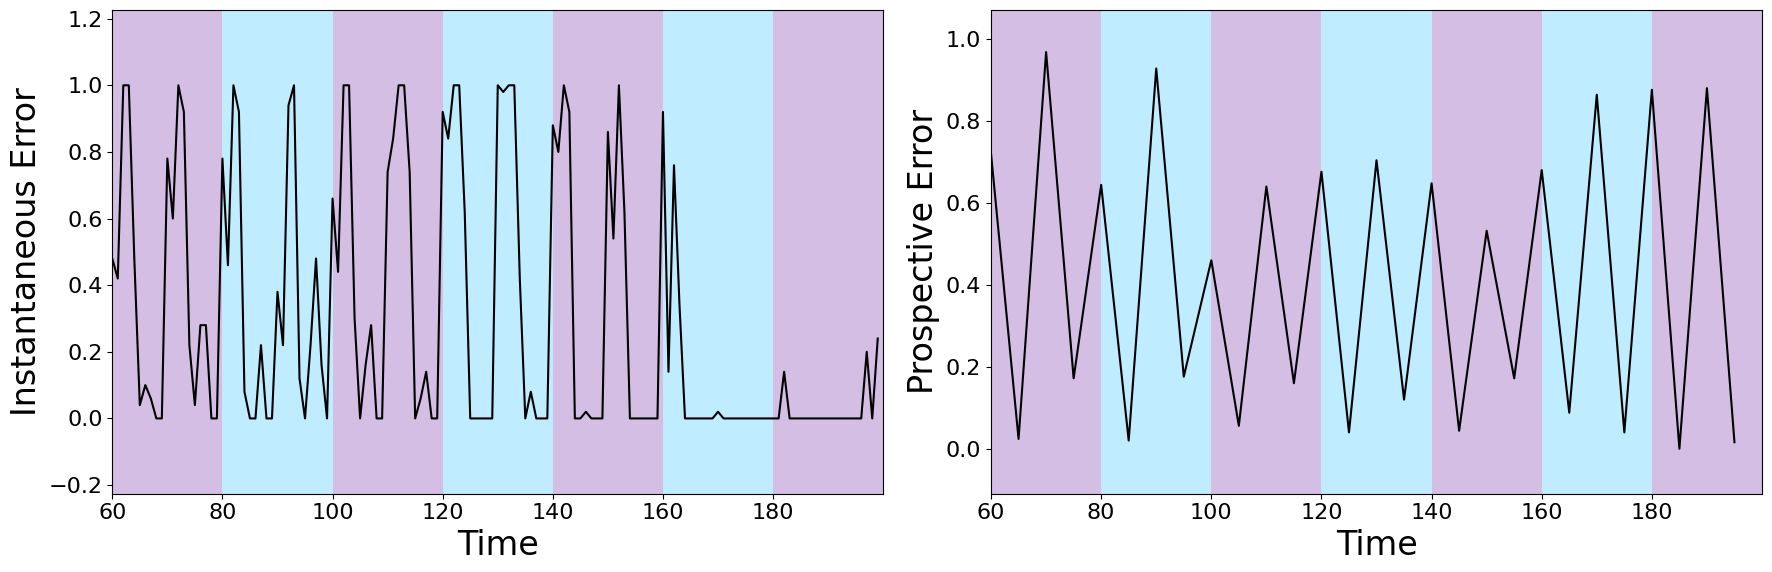

In [67]:
qplot_errors(pl_error, pl_prospective_error,c_pl_error,c_pl_prospective_std, tstart=60,tend=200, col='k',k=5)

In [68]:
def plot_task(ax, task_name, y_offset, colors, fontsize):
    # Plot rectangles and scatter point
    ax.add_patch(Rectangle((-1.5, y_offset), 1, 1, color=colors[0], alpha=1))  # Left rectangle
    ax.add_patch(Rectangle((0.5, y_offset), 1, 1, color=colors[1], alpha=1))   # Right rectangle
    ax.scatter(0, y_offset, color='black', s=10)  # Center point

    ax.set_xlim([-2, 2])  # Extend the x-limits to create more space between rectangles
    ax.set_ylim([-3, 3])  # Adjust ylim to prevent overlapping of Task A and Task B

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

    # for spine in ['left', 'bottom']:
    #     ax.spines[spine].set_linewidth(1)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.axhline(y=y_offset, color='black', linewidth=1)

    ax.set_aspect('equal')

    # Adjust text position based on y_offset
    ax.text(0, y_offset - 1, task_name, fontsize=fontsize, ha='center')

def plot_legend(ax, fontsize):
    colors = {'Chance': '#ff7f00', 'Bayesian GD': '#984ea3', 'Online-SGD': '#4daf4a', 
            'Follow-the-leader': '#377eb8', 'Prospective': '#e41a1c', 'Bayes Risk': 'black'}

    linestyles = {'Chance': '-.', 'Bayesian GD': '-', 'Online-SGD': '-', 
                'Follow-the-leader': '-', 'Prospective': '-', 'Bayes Risk': '--'}

    for label, color in colors.items():
        ax.plot([], [], color=color, linestyle=linestyles[label], label=label)

    legend = ax.legend(frameon=True, loc='center left', ncol=1, fontsize=fontsize, handlelength=1.5, handletextpad=1, borderpad=1, labelspacing=1)

    # legend.get_frame().set_edgecolor('grey')  
    legend.get_frame().set_linewidth(2)  

    ax.axis('off')

def make_plot1(info, title, figname, ax, fontsize, size=50, plot_index=None, subsample=None,
              outside_legend=False, minimal=False, discount=False):
    ax.set_ylim([-0.05, 1])
    ax.set_title(title, fontsize=fontsize)

    cols = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3',
            '#ff7f00', '#ffff33', '#a65628']

    methods = []
    methods_legend = []
    for m in info:
        methods.append(m)
        # print(m)
        if m == 'ERM':
            methods_legend.append('Follow-the-leader')
        else:
            methods_legend.append(m)

    ax.set_ylabel("Prospective Risk", fontsize=fontsize)
    ax.set_xlabel("Time (t)", fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)


    if plot_index is not None:
        methods = [methods[i] for i in plot_index]

    if subsample is not None:
        for m, s in subsample:
            info[methods[m]]= info[methods[m]][:,::s]
            
    for i, m in enumerate(methods):
        ax.plot(info[m][2], info[m][0], c=cols[i])

    # plot chance risk
    if "syn" in figname:
        ax.axhline(y=0.5, color='#ff7f00', linestyle='--')
    # elif "mnist" or "cifar" in figname:
    #     ax.axhline(y=0.742, color='#ff7f00', linestyle='--')

    for i, m in enumerate(methods):
        ax.scatter(info[m][2], info[m][0], c=cols[i], s=size)
        std = 2 * info[m][1] / np.sqrt(5)
        mean = info[m][0]
        ax.fill_between(info[m][2], mean-std, mean+std,
                         alpha=0.3, color=cols[i])

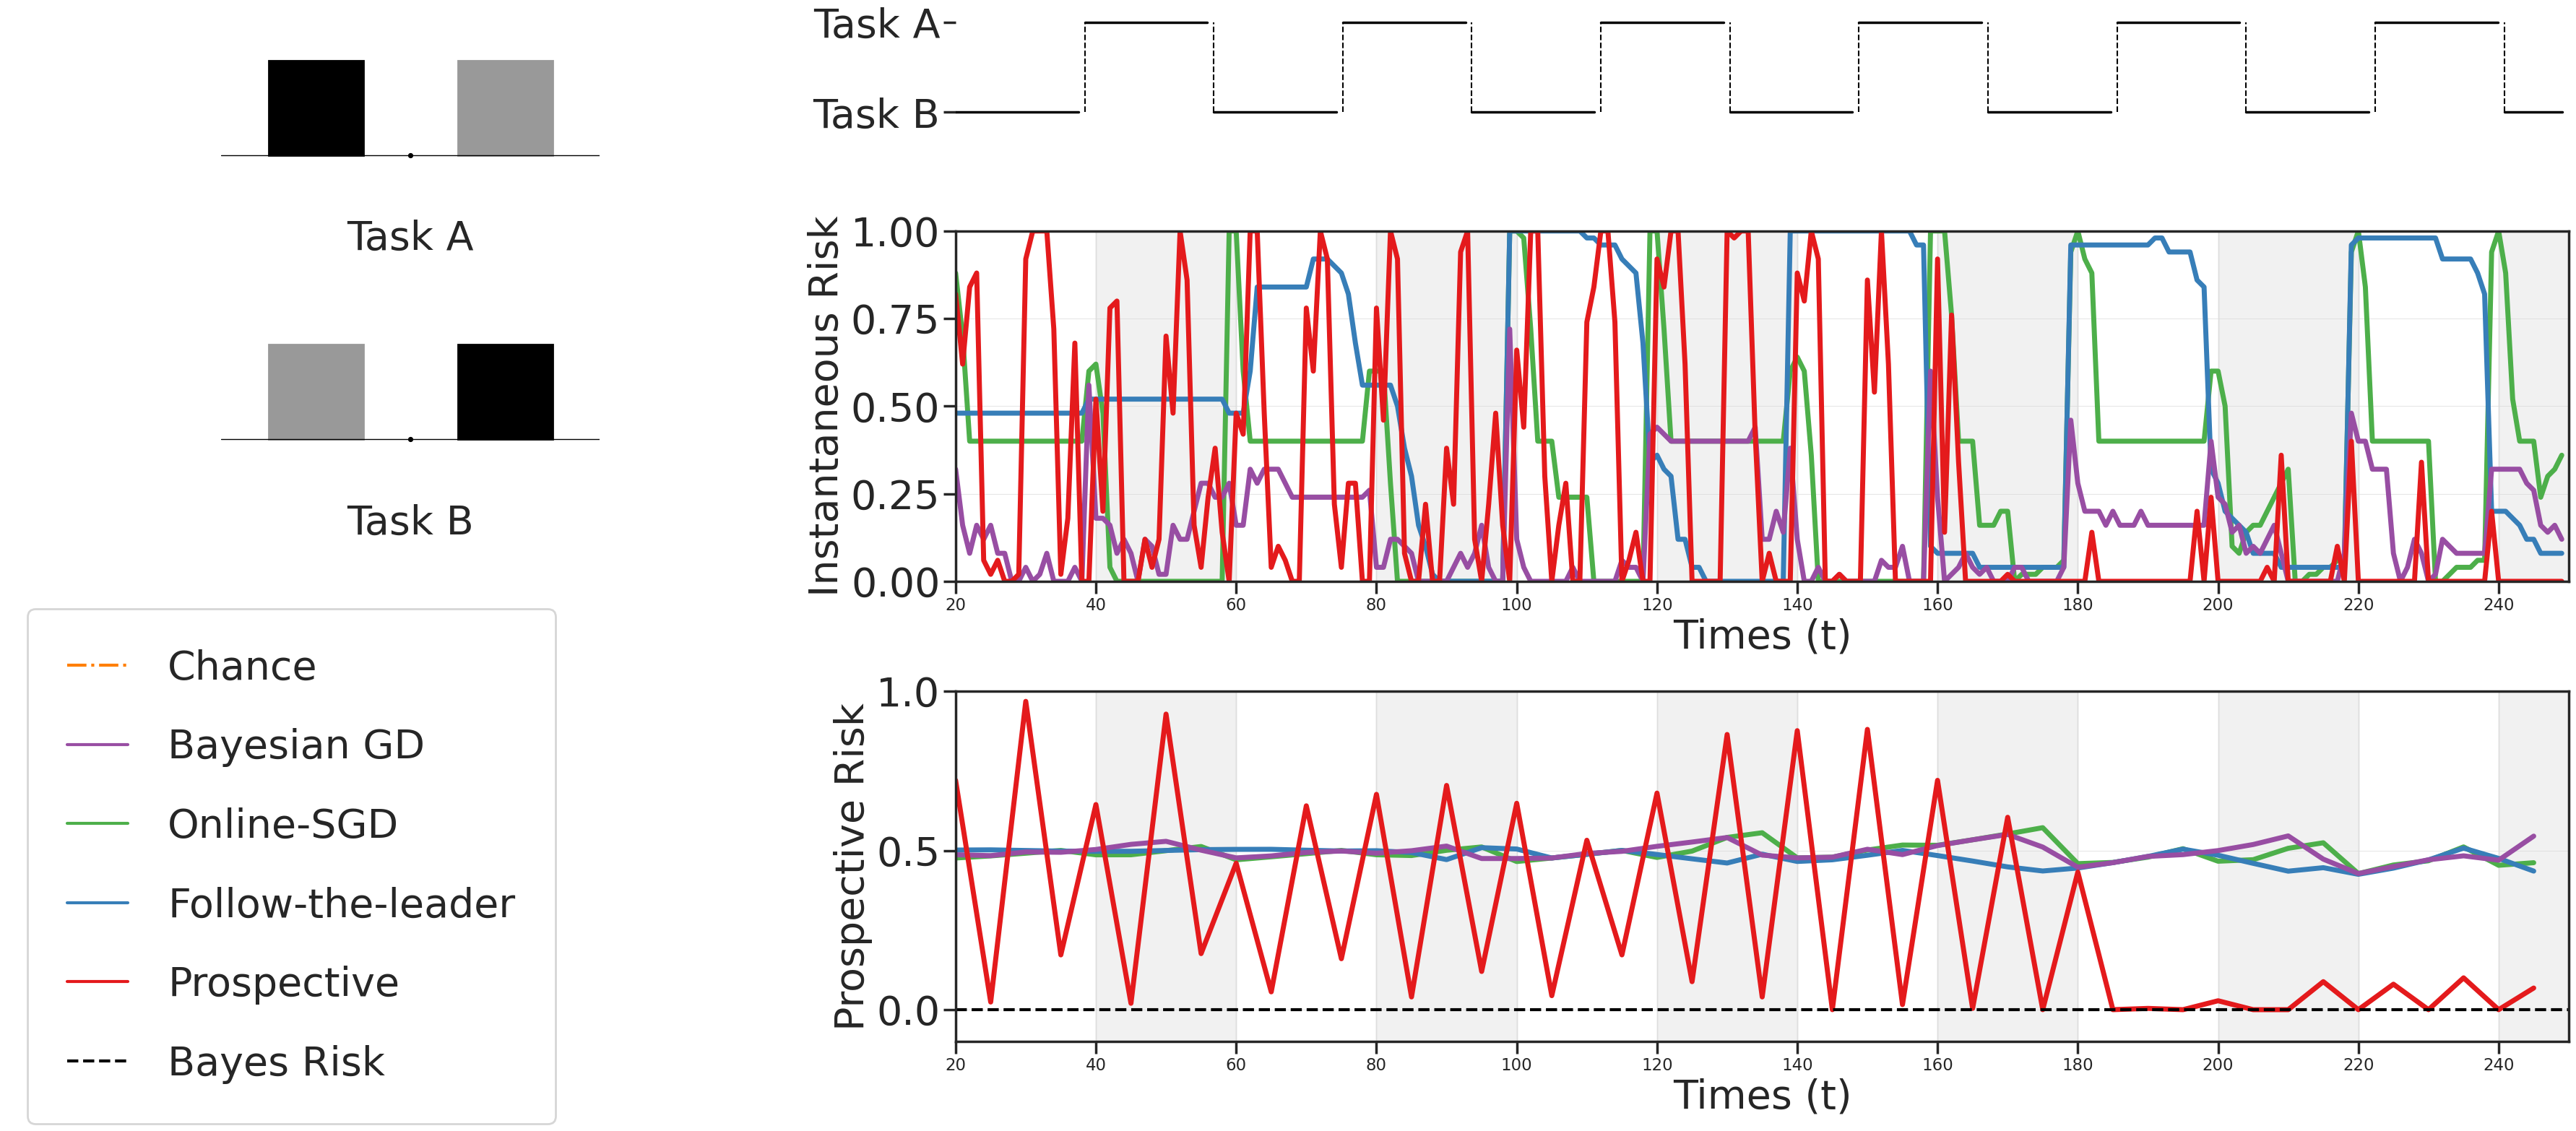

In [ ]:
start_time = 20
end_time = 250
stepsz = 1
fontsize=40

fig = plt.figure(figsize=(36, 16))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 2], height_ratios=[2, 6.5, 6.5])

# First column
axes = {}
axes['left1'] = fig.add_subplot(gs[0:2, 0])  # 'left1' spans rows 0 and 1 in column 0
axes['left2'] = fig.add_subplot(gs[2, 0])    # 'left2' in row 2, column 0

# Second column
axes['right1'] = fig.add_subplot(gs[0, 1])   # 'right1' in row 0, column 1
axes['right2'] = fig.add_subplot(gs[1, 1])   # 'right2' in row 1, column 1
axes['right3'] = fig.add_subplot(gs[2, 1])   # 'right3' in row 2, column 1


plt.subplots_adjust(wspace=0.1, hspace=0.15)

x, y = np.mgrid[-2:2:.1, -2:2:.1]
ax1 = axes['left1']
# Define colors for Task A and Task B
colors_task_A = ['#000000', '#999999']  # Black on the left, gray on the right
colors_task_B = ['#999999', '#000000']  # Gray on the left, black on the right

# Plot Task A at y_offset = 1.5 and Task B at y_offset = -1.5
plot_task(ax1, 'Task A', 1.5, colors_task_A, fontsize)  # Task A with y_offset=1.5
plot_task(ax1, 'Task B', -1.5, colors_task_B, fontsize)  # Task B with y_offset=-1.5

plot_legend(axes['left2'], fontsize)
plot_task_executing(0, end_time, N, fontsize, axes['right1'])

ax = axes['right2']
pl_times = np.arange(tstart,end_time)
ax.plot(pl_times[0:end_time:stepsz], ogd_error[start_time:end_time:stepsz],lw=5,c=colors['OGD'],label='OGD')
ax.plot(pl_times[0:end_time:stepsz], ftl_error[start_time:end_time:stepsz], lw=5,c=colors['FTL'],label='FTL')
ax.plot(pl_times[0:end_time:stepsz], bgd_error[start_time:end_time:stepsz], lw=5,c=colors['BGD'], label='BGD')
ax.plot(pl_times[::stepsz], pl_error[start_time:end_time:stepsz], c=colors['Prospective MLP'], lw=5,label='Prospective MLP')
ax.set_xlabel("Times (t)", fontsize=fontsize)
ax.set_ylabel("Instantaneous Risk", fontsize=fontsize)
ax.set_xticks(np.arange(start_time, end_time, 20))
ax.set_xlim(start_time, end_time)
ax.set_ylim([-0., 1])
ax.tick_params(axis='y', labelsize=fontsize)

ax = axes['right3']
time_points_pros = np.arange(start_time, end_time, k)
ax.plot(time_points_pros, ogd_prospective_error[:len(time_points_pros)], lw=5, c=colors['OGD'], label='OGD')
ax.plot(time_points_pros, ftl_prospective_error[:len(time_points_pros)], lw=5, c=colors['FTL'], label='Follow-the-leader')
ax.plot(time_points_pros, bgd_prospective_error[:len(time_points_pros)], lw=5, c=colors['BGD'], label='Bayesian GD')
ax.plot(time_points_pros, pl_prospective_error[:len(time_points_pros)], lw=5,c=colors['Prospective MLP'], label='Prospective')
ax.axhline(y=0, color='black', linestyle='--',label='Bayes Risk')
ax.set_xlabel("Times (t)", fontsize=fontsize)
ax.set_ylabel("Prospective Risk", fontsize=fontsize)
ax.set_xticks(np.arange(start_time, end_time, 20))
ax.set_xlim(start_time, end_time)


ax.set_ylim([-0.1, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis='y', labelsize=fontsize)

# fig.suptitle('Synthetic Scenario 2', fontsize=fontsize)
for i in range(start_time, end_time, N*2):
    task_b_start = i + N  # Task B starts after Task A
    task_b_end = i + 2 * N  # Task B ends after its 20-second interval

    # Add shading for Task B execution intervals
    axes['right2'].fill_betweenx([-0.1, 1.1], task_b_start, task_b_end, color='lightgray', alpha=0.3)
    axes['right3'].fill_betweenx([-0.1, 1], task_b_start, task_b_end, color='lightgray', alpha=0.3)
    
plt.plot()
plt.tight_layout()
